# 7.8 Lab: Non-linear Modeling



<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#7.8.1-Polynomial-Regression-and-Step-Functions">Polynomial Regression and Step Functions</a></li>
        <li><a href="#7.8.2-Splines">Splines</a></li>
        <li><a href="#7.8.3-GAMs">GAMs</a></li>
    </ol>
</div>


In this lab, we re-analyze the **Wage** data considered in the examples throughout this chapter, in order to illustrate the fact that many of the complex non-linear fitting procedures discussed can be easily implemented in Python

> You can download the **Wage** data set for from **[here](https://drive.google.com/file/d/1puA-UrAstmnJfb7XjJlp6oLK9vb2l9LD/view?usp=sharing)**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# SciKit Learn modules
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrix

We begin by loading the dataset using `pandas`.

In [2]:
wage = pd.read_csv('Wage.csv')
wage.head()

,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [3]:
X = wage.iloc[:, :-2]
y = wage['wage']
age = wage[['age']]

In [4]:
age

,age
0,18
1,24
2,45
3,43
4,50
...,...
2995,44
2996,30
2997,27
2998,27


## _7.8.1 Polynomial Regression and Step Functions_

We first fit the 4th degree model using the `sklearn` features. The function returns a matrix whose columns are a basis of orthogonal polynomials, which essentially means that each column is a linear orthogonal combination of the variables $age$, $age^{2}$, $age^{3}$ and $age^{4}$.

In [5]:
lm = LinearRegression()

poly = PolynomialFeatures(degree=4)
X_tr = poly.fit_transform(age)
model = lm.fit(X_tr, y)

print(model.coef_)

[ 0.00000000e+00  2.12455205e+01 -5.63859312e-01  6.81068771e-03
 -3.20383037e-05]


We now create a grid of values for **age** at which we want predictions, and then call the generic `predict()` function, specifying that we want standard errors as well.

In [6]:
# Create response matrix
y = (wage.wage > 250).map({False:0, True:1}).to_numpy() # Convert the DataFrame to a NumPy array.

# Fit logistic model
logit = sm.GLM(y, X_tr, family=sm.families.Binomial(sm.families.links.logit)).fit()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  """


We now create a grid of values for age at which we want predictions, and then call the generic predict() function, specifying that we want standard errors as well.

In [7]:
# Generate a sequence of age values spanning the range
age_x = np.arange(wage.age.min(), wage.age.max()).reshape(-1,1)

# Generate test data
X = PolynomialFeatures(4).fit_transform(age_x)

# Predict the value of the generated ages
pred2 = logit.predict(X)  # Pr(wage>250)

Finally, we plot the data and add the fit from the degree-4 polynomial.

(-0.01, 0.21)

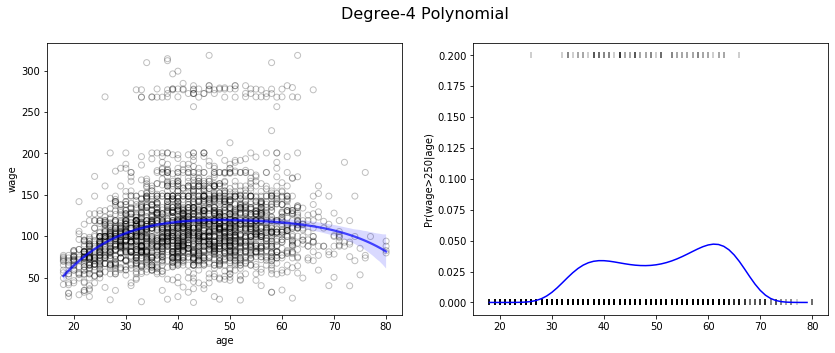

In [8]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,5))
fig.suptitle('Degree-4 Polynomial', fontsize=16)

# use seaborn for a quick polynomial plot
sns.regplot(x='age', y='wage', data=wage, order=4, ax=ax1,
            line_kws={'color':'b', 'alpha':.7},
            scatter_kws={'edgecolors': 'black', 'facecolor': 'None', 'alpha': 0.25})

# ploting the graph with a fitted line
ax2.plot(age_x, pred2, color='blue')
ax2.scatter(wage.age, y/5, s=30, c='black', marker='|', alpha=0.25)
ax2.set_ylabel('Pr(wage>250|age)')
ax2.set_ylim(-0.01,0.21)

In performing a polynomial regression we must decide on the degree of the polynomial to use. One way to do this is by using hypothesis tests. We now fit models ranging from linear to a degree-5 polynomial and seek to determine the simplest model which is sufficient to explain the relationship. Moving Beyond Linearity between **wage** and **age**. We use the `anova_lm()` function, which performs an *analysis of variance* (ANOVA, using an F-test) in order to test the null analysis of hypothesis that a model $M_1$ variance is sufficient to explain the data against the alternative hypothesis that a more complex model $M_2$ is required. In order to use the `anova_lm()` function, $M_1$ and $M_2$ must be nested models: the predictors in $M_1$ must be a subset of the predictors in $M_2$. In this case, we fit five different models and sequentially compare the simpler model to the more complex model.

In [9]:
y = wage['wage']
age = wage[['age']]

In [10]:
# we define 5 global transformed variables for the polynomial plots
for n in range(1, 6):
    poly = PolynomialFeatures(n)
    globals()['X%s' % n] = poly.fit_transform(age)

In [11]:
# We fit five models and define them as global variables
for x, n in zip((X1, X2, X3, X4, X5), range(1, 6)):
    globals()['model%s' % n] = sm.OLS(y, x).fit()

In [12]:
# we compare all models using anova function
anova_table = sm.stats.anova_lm(model1, model2, model3, model4, model5)
print(anova_table)

   df_resid           ssr  df_diff        ss_diff           F        Pr(>F)
0    2998.0  5.022216e+06      0.0            NaN         NaN           NaN
1    2997.0  4.793430e+06      1.0  228786.010128  143.593107  2.363850e-32
2    2996.0  4.777674e+06      1.0   15755.693664    9.888756  1.679202e-03
3    2995.0  4.771604e+06      1.0    6070.152124    3.809813  5.104620e-02
4    2994.0  4.770322e+06      1.0    1282.563017    0.804976  3.696820e-01


C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


The p-value comparing the linear Model 1 to the quadratic **Model 2** is essentially zero (<$10^{−15}$), indicating that a linear fit is not sufficient. Similarly the p-value comparing the quadratic **Model 2** to the cubic **Model 3** is very low (0.0017), so the quadratic fit is also insufficient. The p-value comparing the cubic and degree-4 polynomials, Model 3 and **Model 4**, is approximately 5% while the degree-5 polynomial **Model 5** seems unnecessary because its p-value is 0.37. Hence, either a cubic or a quartic polynomial appear to provide a reasonable fit to the data, but lower- or higher-order models are not justified.

-----------
In order to fit a step function, as discussed in Section 7.2, we use the
`pandas.cut()` function.

In [13]:
wage_cut, bins = pd.cut(wage.age, 4, retbins=True, right=True) # we cut x variable in 4 bins
wage_cut.value_counts(sort = False)

(17.938, 33.5]     750
(33.5, 49.0]      1399
(49.0, 64.5]       779
(64.5, 80.0]        72
Name: age, dtype: int64

Here `cut()` automatically picked the cutpoints at 33.5, 49, and 64.5 years of age. We could also have specified our own cutpoints directly. Now let's create a set of dummy variables for use in the regression:

In [14]:
df_steps = pd.concat([wage.age, wage_cut, wage.wage], keys = ['age', 'cuts', 'wage'], axis = 1)

# Create dummies for the age bins
step_dummies = pd.get_dummies(df_steps['cuts'])

Next we add a constant as statsmodels doesn't perfor mregression automatically using a constan for an intercept. After that we will get rid of the first bin (17.938 - 33.5] interval.

In [15]:
# adding constant
step_dummies = sm.add_constant(step_dummies)

# dropping the first category
step_dummies = step_dummies.drop(step_dummies.columns[1], axis = 1)

step_dummies.head()

,const,"(33.5, 49.0]","(49.0, 64.5]","(64.5, 80.0]"
0,1.0,0,0,0
1,1.0,0,0,0
2,1.0,1,0,0
3,1.0,1,0,0
4,1.0,0,1,0


Finally we fit the model:

In [16]:
step_model = sm.GLM(wage['wage'], step_dummies).fit()
step_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   wage   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2996
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                          1634.1
Method:                          IRLS   Log-Likelihood:                -15353.
Date:                Fri, 15 May 2020   Deviance:                   4.8957e+06
Time:                        12:52:03   Pearson chi2:                 4.90e+06
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           94.1584      1.476     63.790      0.000      91.265      97.051
(33.5, 49.0]    24.0535      1.829     13.148      0.000      20.468      27.639
(49.0, 64.5]    23.6646      2.068     11.443      0.000      19.611      27.718
(64.5, 80.0]     7.6406      4.987      1.532      0.126      -2.135      17.416
================================================================================
"""

The **age<33.5** category is left out, so the intercept coefficient of $94,160 can be interpreted as the average salary for those under 33.5 years of age, and the other coefficients can be interpreted as the average additional salary for those in the other age groups. We can produce predictions and plots just as we did in the case of the polynomial fit.

We can produce predictions and plots just as we did in the case of the polynomial fit.

In [17]:
# Put the test data in the same bins as the training data.
bin_mapping = np.digitize(age_x.ravel(), bins)

# Get dummies, drop first dummy category, add constant
X = sm.add_constant(pd.get_dummies(bin_mapping).drop(1, axis = 1))

# Predict the value of the generated ages using the linear model
pred3 = step_model.predict(X)

(0, 333.26741599354926)

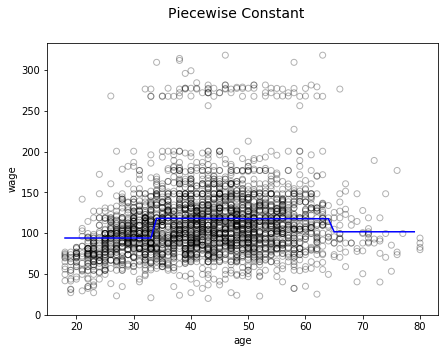

In [18]:
# Plot
fig, ax1 = plt.subplots(figsize = (7,5))
fig.suptitle('Piecewise Constant', fontsize = 14)

# Left Graph on 7.2
ax1.scatter(wage.age, wage.wage, facecolor = 'None', edgecolor = 'k', alpha = 0.3)
ax1.plot(age_x, pred3, c = 'b')

ax1.set_xlabel('age')
ax1.set_ylabel('wage')
ax1.set_ylim(ymin = 0)

-------------
## _7.8.2 Splines_

In order to fit regression splines we use the splines library from `statsmodels`. We saw that regression splines can be fit by constructing an appropriate matrix of basis functions. The  `bs()` function generates the entire matrix of basis functions for splines with the specified set of knots.

We start by generating cubic spline with 3 knots at 25, 40 and 60.

In [19]:
matrix_X1 = dmatrix("bs(wage['age'], knots=(25,40,60), degree=3, include_intercept=False)",
                        {"wage['age']": wage['age']}, return_type='dataframe')

Fit the General Linear Model

In [20]:
s_fit1 = sm.GLM(wage['wage'], matrix_X1).fit()
s_fit1.params

Intercept                                                                    60.493714
bs(wage['age'], knots=(25, 40, 60), degree=3, include_intercept=False)[0]     3.980500
bs(wage['age'], knots=(25, 40, 60), degree=3, include_intercept=False)[1]    44.630980
bs(wage['age'], knots=(25, 40, 60), degree=3, include_intercept=False)[2]    62.838788
bs(wage['age'], knots=(25, 40, 60), degree=3, include_intercept=False)[3]    55.990830
bs(wage['age'], knots=(25, 40, 60), degree=3, include_intercept=False)[4]    50.688098
bs(wage['age'], knots=(25, 40, 60), degree=3, include_intercept=False)[5]    16.606142
dtype: float64

Here we have prespecified knots at ages 25, 40, and 60. This produces a spline with six basis functions. (Recall that a cubic spline with three knots has seven degrees of freedom; these degrees of freedom are used up by an intercept, plus six basis functions). We could also use the `df` option to produce a spline with knots at uniform quantiles of the data.

In [21]:
matrix_X2 = dmatrix("bs(wage['age'], df=6, include_intercept=False)",
                        {"wage['age']": wage['age']}, return_type='dataframe')

In [22]:
s_fit2 = sm.GLM(wage['wage'], matrix_X2).fit()
s_fit2.params

Intercept                                            56.313841
bs(wage['age'], df=6, include_intercept=False)[0]    27.824002
bs(wage['age'], df=6, include_intercept=False)[1]    54.062546
bs(wage['age'], df=6, include_intercept=False)[2]    65.828391
bs(wage['age'], df=6, include_intercept=False)[3]    55.812734
bs(wage['age'], df=6, include_intercept=False)[4]    72.131473
bs(wage['age'], df=6, include_intercept=False)[5]    14.750876
dtype: float64

In this case Python chooses knots at ages 33.8, 42.0, and 51.0, which correspond to the 25th, 50th, and 75th percentiles of age.

In this case python chooses knots which correspond to the 25th, 50th, and 75th percentiles of **age**. The function `bs()` also has a `degrees` argument, so we can fit splines of any degree, rather than the default degree of 3 (which yields a cubic spline).

In order to instead fit a natural spline, we use the `cr()` function. Here we fit a natural spline with four degrees of freedom:

In [23]:
matrix_X3 = dmatrix("cr(wage['age'], df=4)",
                    {"wage['age']": wage['age']},
                    return_type='dataframe')

s_fit3 = sm.GLM(wage['wage'], matrix_X3).fit()
s_fit3.params

Intercept                   79.642095
cr(wage['age'], df=4)[0]   -14.667784
cr(wage['age'], df=4)[1]    36.811142
cr(wage['age'], df=4)[2]    35.934874
cr(wage['age'], df=4)[3]    21.563863
dtype: float64

In [24]:
matrix_X4 = dmatrix("bs(wage['age'], knots=(25, 40, 50, 65), degree =3, include_intercept=False)",
                    {"wage['age']": wage['age']}, return_type='dataframe')
s_fit4 = sm.GLM(wage['wage'], matrix_X4).fit()
s_fit4.params

Intercept                                                                        58.469971
bs(wage['age'], knots=(25, 40, 50, 65), degree=3, include_intercept=False)[0]    10.482606
bs(wage['age'], knots=(25, 40, 50, 65), degree=3, include_intercept=False)[1]    40.061614
bs(wage['age'], knots=(25, 40, 50, 65), degree=3, include_intercept=False)[2]    67.158234
bs(wage['age'], knots=(25, 40, 50, 65), degree=3, include_intercept=False)[3]    53.848170
bs(wage['age'], knots=(25, 40, 50, 65), degree=3, include_intercept=False)[4]    72.748671
bs(wage['age'], knots=(25, 40, 50, 65), degree=3, include_intercept=False)[5]    21.134602
bs(wage['age'], knots=(25, 40, 50, 65), degree=3, include_intercept=False)[6]    33.407196
dtype: float64

Lets reproduce the Figure 7.8:

In [25]:
x_axes = np.arange(wage['age'].min(), wage['age'].max())

# Make prediction for the fitted line
pred1 = s_fit1.predict(dmatrix("bs(x_axes, knots=(25,40,60), include_intercept=False)",
                             {"x_axes": x_axes}, return_type='dataframe'))

pred2 = s_fit2.predict(dmatrix("bs(x_axes, df=6, include_intercept=False)",
                        {"x_axes]": x_axes}, return_type='dataframe'))

# Generating natural cubic spline
pred3 = s_fit3.predict(dmatrix("cr(x_axes, df=4)",
                             {"x_axes": x_axes}, return_type='dataframe'))

pred4 = s_fit4.predict(dmatrix("bs(x_axes, knots=(25, 40, 50, 65), degree =3, include_intercept=False)",
                             {"x_axes": x_axes}, return_type='dataframe'))

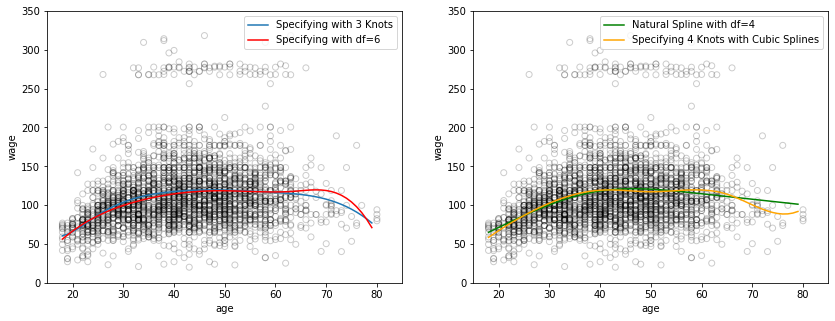

In [26]:
# Plot the splines and error bands
fig, ax = plt.subplots(1,2, figsize=(14, 5))

ax[0].scatter(wage.age, wage.wage, facecolor='None', edgecolor='k', alpha=0.2)
ax[0].plot(x_axes, pred1, label='Specifying with 3 Knots')
ax[0].plot(x_axes, pred2, color='r', label='Specifying with df=6')
ax[0].legend()
ax[0].set_xlim(15,85)
ax[0].set_ylim(0,350)
ax[0].set_xlabel('age')
ax[0].set_ylabel('wage')

ax[1].scatter(wage.age, wage.wage, facecolor='None', edgecolor='k', alpha=0.2)
ax[1].plot(x_axes, pred3, label='Natural Spline with df=4', color='green')
ax[1].plot(x_axes, pred4, color='orange', label='Specifying 4 Knots with Cubic Splines')
ax[1].legend()
ax[1].set_xlim(15,85)
ax[1].set_ylim(0,350)
ax[1].set_xlabel('age')
ax[1].set_ylabel('wage')

plt.show()

----------
## _7.8.3_ GAMs
We now fit a GAM to predict **wage** using natural spline functions of **year** and **age**, treating **education** as a qualitative predictor

In [28]:
from statsmodels.gam.api import GLMGam, BSplines

wage.head(3)

,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177


In [81]:
# Create dummies for education and Drop 'HS Grad' which will be base
df_gams = pd.concat([wage[['year', 'age', 'wage']], pd.get_dummies(wage['education']).drop('1. < HS Grad', axis=1)], axis=1)
df_gams.rename(columns={'2. HS Grad': 'high_school', '3. Some College': 'some_college',
                        '4. College Grad': 'college_grad', '5. Advanced Degree': 'advanced_degree'}, inplace=True)
df_gams.head()

,year,age,wage,high_school,some_college,college_grad,advanced_degree
0,2006,18,75.043154,0,0,0,0
1,2004,24,70.476020,0,0,1,0
2,2003,45,130.982177,0,1,0,0
3,2003,43,154.685293,0,0,1,0
4,2005,50,75.043154,1,0,0,0


In [79]:
# create spline basis for year and age
edu_spline = df_gams.iloc[:, 3:]
x_spline = df_gams[['year', 'age']]
bs = BSplines(x_spline, df=[4, 5], degree=[3, 3])

In [85]:
gam_bs = GLMGam.from_formula('wage ~ year + age + high_school + some_college + college_grad + advanced_degree',
                             data=df_gams, smoother=bs).fit()
gam_bs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   wage   No. Observations:                 3000
Model:                         GLMGam   Df Residuals:                     2988
Model Family:                Gaussian   Df Model:                        11.00
Link Function:               identity   Scale:                          1238.8
Method:                         PIRLS   Log-Likelihood:                -14934.
Date:                Fri, 15 May 2020   Deviance:                   3.7014e+06
Time:                        14:02:25   Pearson chi2:                 3.70e+06
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0392      0.011     -3.610      0.000      -0.060      -0.018
year                0.0140      0.003      4.058      0.000       0.007       0.021
age                 0.7581      0.119      6.357      0.000       0.524       0.992
high_school        10.7413      2.431      4.418      0.000       5.977      15.506
some_college       23.2067      2.563      9.056      0.000      18.184      28.229
college_grad       37.8704      2.547     14.871      0.000      32.879      42.862
advanced_degree    62.4355      2.764     22.591      0.000      57.019      67.852
year_s0             6.6751      4.973      1.342      0.179      -3.071      16.421
year_s1             5.1473      4.238      1.215      0.224      -3.158      13.453
year_s2             7.4307      2.345      3.169      0.002       2.834      12.027
age_s0             20.8337      7.174      2.904      0.004       6.772      34.895
age_s1             42.7028      5.144      8.301      0.000      32.621      52.785
age_s2             -4.1790      8.874     -0.471      0.638     -21.572      13.214
age_s3            -19.0837      6.675     -2.859      0.004     -32.166      -6.001
===================================================================================
"""

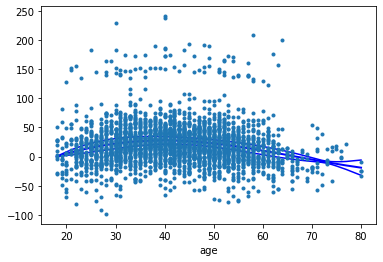

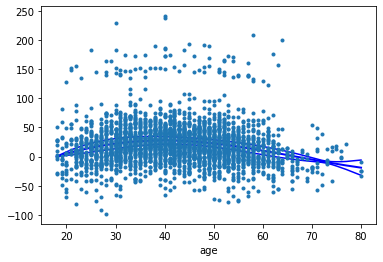

In [104]:
gam_bs.plot_partial(1, cpr=True)